In [ ]:
!git clone https://github.com/intelpro/RE510_experiment3
%cd RE510_experiment3/monodepth/
!mkdir saved_ckpt
!ls
from google.colab import drive
drive.mount('/content/gdrive/')

## import로 모듈 가져오기
### torch에 있는 module, 우리가 사전에 정의해놓았던 함수 등 import로 가져온다. 

In [1]:
import time
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from utils import get_model, to_device, prepare_dataloader
import matplotlib.pyplot as plt
import matplotlib as mpl
from configs import get_config
from data_loader import KittiLoader
from torch.utils.data import DataLoader, ConcatDataset
from transforms import image_transforms

## Image reconstruction loss를 위한 SSIM 함수 정의하기
### \\( SSIM(x,y) =\frac{2\mu_x\mu_y+C_1}{\sigma_{x}\sigma_{x}+C_2} \\)
#### 여기서 SSIM에서 x,y는 reference 이미지로 부터 sampling한 패치 y는 target 이미지로 부터 sampling한 패치를 의미함. 
#### 보통 patch size는 5나 3을 많이 사용
#### image reconstruction loss에서 L1 loss와 SSIM loss를 합쳐서 사용한다.

In [2]:
def SSIM(x, y):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    mu_x = nn.AvgPool2d(3, 1)(x)
    mu_y = nn.AvgPool2d(3, 1)(y)
    mu_x_mu_y = mu_x * mu_y
    mu_x_sq = mu_x.pow(2)
    mu_y_sq = mu_y.pow(2)

    sigma_x = nn.AvgPool2d(3, 1)(x * x) - mu_x_sq
    sigma_y = nn.AvgPool2d(3, 1)(y * y) - mu_y_sq
    sigma_xy = nn.AvgPool2d(3, 1)(x * y) - mu_x_mu_y

    SSIM_n = (2 * mu_x_mu_y + C1) * (2 * sigma_xy + C2)
    SSIM_d = (mu_x_sq + mu_y_sq + C1) * (sigma_x + sigma_y + C2)
    SSIM = SSIM_n / SSIM_d
    return torch.clamp((1 - SSIM) / 2, 0, 1)

## Disparity smoothness 정의하기
#### disparity smoothness 를 정의하기 위해서는 image와 disparity의 gradient의 계산이 필요하다. 
#### image와 disparity의 gradient를 구한 뒤, image gradient의 방향과 disparity의 방향이 비슷하도록 smoothness loss를 정의해준다.

In [3]:
def disp_smoothness(disp, pyramid):
    def gradient_x(img):
        # Pad input to keep output size consistent
        img = F.pad(img, (0, 1, 0, 0), mode="replicate")
        gx = img[:, :, :, :-1] - img[:, :, :, 1:]  # NCHW
        return gx
    def gradient_y(img):
        # Pad input to keep output size consistent
        img = F.pad(img, (0, 0, 0, 1), mode="replicate")
        gy = img[:, :, :-1, :] - img[:, :, 1:, :]  # NCHW
        return gy
    disp_gradients_x = [gradient_x(d) for d in disp]
    disp_gradients_y = [gradient_y(d) for d in disp]

    image_gradients_x = [gradient_x(img) for img in pyramid]
    image_gradients_y = [gradient_y(img) for img in pyramid]

    weights_x = [torch.exp(-torch.mean(torch.abs(g), 1, keepdim=True)) for g in image_gradients_x]
    weights_y = [torch.exp(-torch.mean(torch.abs(g), 1, keepdim=True)) for g in image_gradients_y]

    smoothness_x = [disp_gradients_x[i] * weights_x[i] for i in range(4)]
    smoothness_y = [disp_gradients_y[i] * weights_y[i] for i in range(4)]

    return [torch.abs(smoothness_x[i]) + torch.abs(smoothness_y[i]) for i in range(4)]

## Disparity를 사용하여 warping을 수행하여보자(apply_disparity 함수)
#### 우리가 구한 disparity는 left image와 right image와의 관계이다. 
#### 따라서, disparity정보를 사용하여 left 이미지를 right 이미지로 만들어 줄 수 있고, right image를 left 이미지로 만들어 줄 수 있다. 
#### 이 정보를 사용하여 image reconstruction loss를 측정하게 된다.

In [4]:
def apply_disparity(img, disp):
    batch_size, _, height, width = img.size()
    # Original coordinates of pixels
    x_base = torch.linspace(0, 1, width).repeat(batch_size, height, 1).type_as(img)
    y_base = torch.linspace(0, 1, height).repeat(batch_size, width, 1).transpose(1, 2).type_as(img)

    # Apply shift in X direction
    x_shifts = disp[:, 0, :, :]  # Disparity is passed in NCHW format with 1 channel
    flow_field = torch.stack((x_base + x_shifts, y_base), dim=3)
    # In grid_sample coordinates are assumed to be between -1 and 1
    output = F.grid_sample(img, 2*flow_field - 1, mode='bilinear', padding_mode='zeros')
    return output

def generate_image_left(img, disp):
    return apply_disparity(img, -disp)

def generate_image_right(img, disp):
    return apply_disparity(img, disp)

### 여러 scale의 이미지를 만들어보자.(scale pyramid 함수)
#### scale에 따라서, 작은 이미지부터 큰 사이즈의 이미지를 만드는 함수.

In [5]:
def scale_pyramid(img, num_scales):
    scaled_imgs = [img]
    s = img.size()
    h = s[2]
    w = s[3]
    for i in range(num_scales - 1):
        ratio = 2 ** (i + 1)
        nh = h // ratio
        nw = w // ratio
        scaled_imgs.append(nn.functional.interpolate(img,size=[nh, nw], mode='bilinear', align_corners=True))
    return scaled_imgs

## Loss function for monodepth
### =============== 1. image reconstruction loss ===============
### left image와 left disparity를 사용하여 generated right image를 생성한다
### Image reconstruction loss(left) = || real right image - generated right image || + SSIM(real, generated)
### Image reconstruction loss(right) = || real left image - generated left image || + SSIM(real, generated)
### Image reconstruction loss = Image reconstruction loss(left) + Image reconstruction loss(right)
### \\( L_{image} = L_{image, left} + L_{image, right} \\)
### =============== 2. disparity smoothness loss ===============
### \\( L(d, I) = \frac{1}{N}\sum_{i,j}|\partial_{x}d_{ij}^{l}|e^{-|\partial_{x}I_{ij}^{l}|} + |\partial_{y}d_{ij}^{l}|e^{-|\partial_{y}I_{ij}^{l}|}  \\)
#### image와 disparity의 gradient를 구한 뒤, image gradient의 방향과 disparity의 방향이 비슷하도록 smoothness loss를 정의해준다.
### =============== 3. left-right consistency loss ===============
### \\( L_{lr} = \frac{1}{N}  \sum_{i,j}|d_{ij}^l - d_{ij+d_{ij}^{l}}^r | \\)
### left disparity를 right disparity로 warping, right disparity를 left disparity로 warping
#### left right consistency loss = | generated right disparity - right disparity | + | generated left disparity - left disparity |
### =============== 4. total loss ===============
### 총 loss = image reconstruction loss + disparity smoothness loss + left-right consistency loss

In [6]:
def loss_function(left, right, disp, params):
    """
    Args:
        input [disp1, disp2, disp3, disp4]
        target [left, right]
    Return:
        (float): The loss
    """
    left_pyramid = scale_pyramid(left, params["n_scale"])
    right_pyramid = scale_pyramid(right, params["n_scale"])

    # Prepare disparities
    disp_left_est = [d[:, 0, :, :].unsqueeze(1) for d in disp]
    disp_right_est = [d[:, 1, :, :].unsqueeze(1) for d in disp]
    
    # Generate images(for image reconstruction loss)
    left_est = [generate_image_left(right_pyramid[i], disp_left_est[i]) for i in range(params["n_scale"])]
    right_est = [generate_image_right(left_pyramid[i],  disp_right_est[i]) for i in range(params["n_scale"])]
    
    # L1 loss(image reconstruction loss)
    l1_left = [torch.mean(torch.abs(left_est[i] - left_pyramid[i])) for i in range(params["n_scale"])]
    l1_right = [torch.mean(torch.abs(right_est[i] - right_pyramid[i])) for i in range(params["n_scale"])]

    # SSIM loss(image reconstruction loss)
    ssim_left = [torch.mean(SSIM(left_est[i],left_pyramid[i])) for i in range(params["n_scale"])]
    ssim_right = [torch.mean(SSIM(right_est[i],right_pyramid[i])) for i in range(params["n_scale"])]

    image_loss_left = [params["SSIM_w"] * ssim_left[i]+ (1 - params["SSIM_w"]) * l1_left[i] for i in range(params["n_scale"])]
    image_loss_right = [params["SSIM_w"] * ssim_right[i]+ (1 - params["SSIM_w"]) * l1_right[i] for i in range(params["n_scale"])]
    image_loss = sum(image_loss_left + image_loss_right)
    
    # Disparities smoothness
    disp_left_smoothness = disp_smoothness(disp_left_est, left_pyramid)
    disp_right_smoothness = disp_smoothness(disp_right_est, right_pyramid)

    # Disparities smoothness
    disp_left_loss = [torch.mean(torch.abs(disp_left_smoothness[i])) / 2 ** i for i in range(params["n_scale"])]
    disp_right_loss = [torch.mean(torch.abs(disp_right_smoothness[i])) / 2 ** i  for i in range(params["n_scale"])]
    disp_gradient_loss = sum(disp_left_loss + disp_right_loss)

    # Left-Right Consistency
    right_left_disp = [generate_image_left(disp_right_est[i], disp_left_est[i]) for i in range(params["n_scale"])]
    left_right_disp = [generate_image_right(disp_left_est[i], disp_right_est[i]) for i in range(params["n_scale"])]
    
    # Left-Right Consistency
    lr_left_loss = [torch.mean(torch.abs(right_left_disp[i]- disp_left_est[i])) for i in range(params["n_scale"])]
    lr_right_loss = [torch.mean(torch.abs(left_right_disp[i] - disp_right_est[i])) for i in range(params["n_scale"])]
    lr_loss = sum(lr_left_loss + lr_right_loss)

    loss = image_loss + params["disp_grad_w"] * disp_gradient_loss + params["lr_w"] * lr_loss
    return loss

## main function 
### model을 정의하고 print 해봅시다. 
#### 우리의 network는 resnet-18 모델을 변형하여 만든 모델입니다. 

In [12]:
if __name__== '__main__':
    params = {}
    params = get_config(params)
    model = get_model(params["model"])
    optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])
    print(model)

Resnet18_md(
  (conv1): conv(
    (conv_base): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
    (normalize): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): maxpool()
  (conv2): Sequential(
    (0): resconv_basic(
      (conv1): conv(
        (conv_base): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
        (normalize): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv2): conv(
        (conv_base): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (normalize): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
      (normalize): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): resconv_basic(
      (conv1): conv(
        (conv_base): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (normalize): BatchNorm2d(64, eps=1e-05,

## data loader, data augmentation을 정의합니다. 

In [13]:
    model = model.cuda()
    data_transform = image_transforms(
                     mode=params["mode"], augment_parameters=params["augment_parameters"],
                     do_augmentation=params["do_augmentation"], size = (params["input_height"], params["input_width"]))
    datasets = KittiLoader(params["data_dir"], params["mode"], transform=data_transform)
    datasets_no_trans = KittiLoader(params["data_dir"], params["mode"])
    loader = DataLoader(datasets, batch_size=params["batch_size"],
                    shuffle=True, num_workers=params["num_workers"],pin_memory=True)
    params["data_loader"] = loader
    print("data loader object: ", params["data_loader"])
    params["n_img"] = len(params["data_loader"])

data loader object:  <torch.utils.data.dataloader.DataLoader object at 0x7fc8d4326780>


## 정의된 data loader를 사용하여 left, right image를 plot 해봅시다. 
### 우리의 모델은 unsupervised learning 기반이기 때문에 필요한 것은 오로지 left 이미지와 right image 이미지 뿐입니다. 
### 왼쪽 이미지와 오른쪽 이미지가 살짝 다른것이 보이시나요?? 

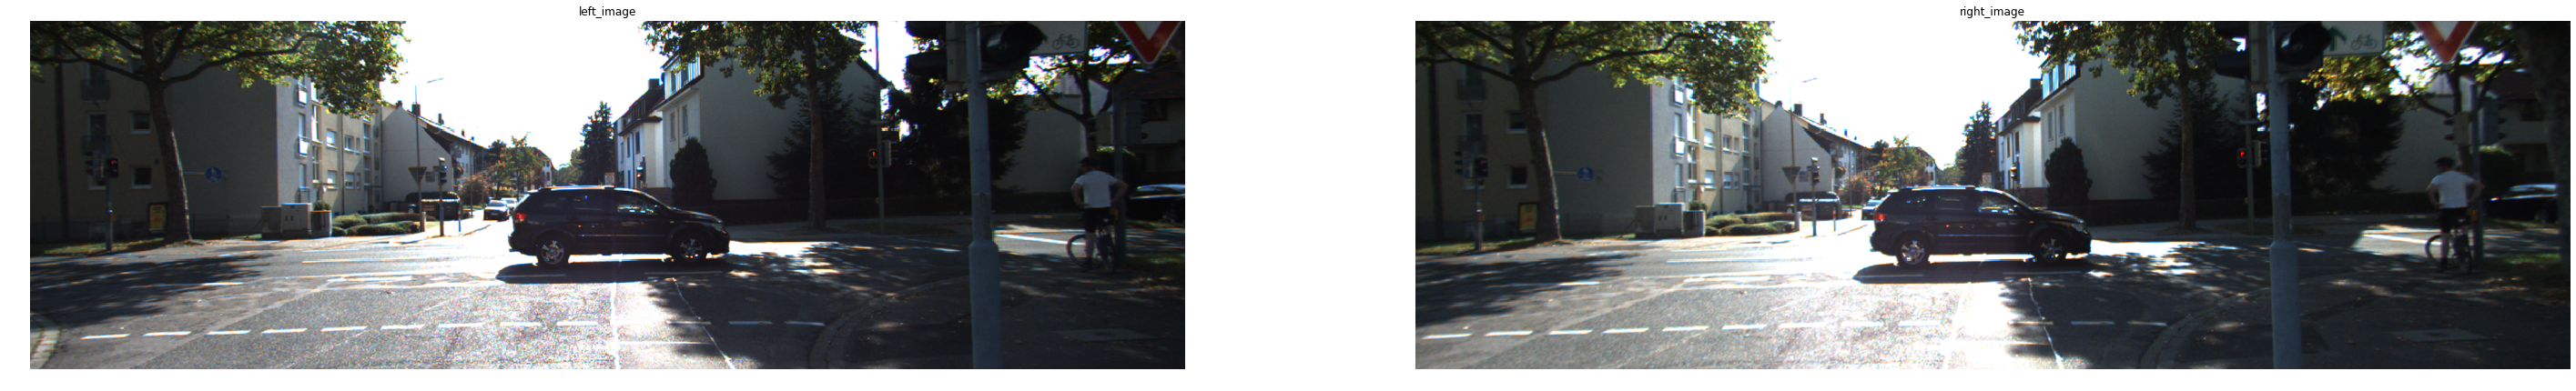

In [14]:
    sample = datasets_no_trans.__getitem__(0)
    fig = plt.figure(figsize=(50, 50))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title("left_image")
    ax1.imshow(sample["left_image"])
    ax1.axis("off")
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title("right_image")
    ax2.imshow(sample["right_image"])
    ax2.axis("off")
    plt.show()

### 정의된 data loader를 사용하여 image의 shape를 print해봅니다.
###  pytorch의 경우 (Batch size, channel, height, width)의 형태입니다. 

In [15]:
    it = iter(params["data_loader"])
    hello = next(it)
    print(hello['left_image'].shape)

torch.Size([20, 3, 256, 512])


### 학습을 위한 for loop 

In [ ]:
    losses = []
    best_loss = float('Inf')
    for epoch in range(params["epochs"]):
        c_time = time.time()
        running_loss = 0.0
        model.train()
        for (i, data) in enumerate(params["data_loader"]):
            # Load data
            data = to_device(data, params["device"])
            left = data['left_image']
            right = data['right_image']
            # One optimization iteration
            optimizer.zero_grad()
            # get disparity 
            disps = model(left)
            # get loss function
            loss = loss_function(left, right, disps, params)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            running_loss += loss.item()
        # Estimate loss per image
        running_loss /= params["n_img"] / params["batch_size"]
        print ('Epoch:',epoch + 1, 'train_loss:', running_loss, 'time:', round(time.time() - c_time, 3),'s',)
        torch.save(model.state_dict(), params["model_path"]+ "/epoch_" + str(epoch) + '.pth')
    print ('Finished Training. Best loss:', best_loss)
    torch.save(model.state_dict(), params["model_path"] + '/last.pth')